## Resources
* Tensorflow 2.1

## Triplet Loss explained:

Figures taken from paper introducing Facenet(1). **Figure 2** represents the general idea of encoding images into a series of numbers much smaller than the image's size.

**Figure 3** presents the manner of training the network to differentiate between intra-class and inter-class cases. By pairing the images into triplet pairs of *Anchor-Positive* and *Anchor-Negative*, the network learns the distribution of images from each class with respect to all other classes.


Let's import some necessary functions

In [1]:
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential,Input,Model

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### include the necessary functions for triplet loss:
** (from TF libraries) **

In [3]:
def pairwise_distance(feature, squared=True):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

## Define our Triplet Loss

In [4]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]

 
    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
    
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size  
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance

### Define our base_model

having the structure
![alt text](images/base_network.png "Logo Title Text 1")

In [6]:
imgsize=96
def create_base_network(image_input_shape, embedding_size):
    
    base_model = MobileNetV2(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
#     model.add(Dropout(0.3))
#     model.add(Dense(1024))
    # model.add(Dropout(0.5))
    model.add(Dense(258))
    # model = create_model()
#     model.load_weights("../mobileNetV2Model/MobileNetV2model.h5")
    
    model.summary()

    # SVG(model_to_dot(model).create(prog='dot', format='svg'))
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model

### Loading the training/validation/testing DATA, as well as some other parameters

In [7]:
import cv2
import glob
import tqdm

In [8]:
def assign_label(label):
    return label
def training_data(label,data_dir, imgsize):
    X = []
    Y = []
    count = 0
    for path in tqdm.tqdm(glob.glob(data_dir + "/*")):
#         print(path)
        label = assign_label(label)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (imgsize, imgsize))
        X.append(np.array(img))
        Y.append(str(label))
        count = count + 1
        if count>51:
            break
    return X,Y

In [9]:
c = []
d = []
f = '../cust_div/train/999999981442'
train_path = '../cust_div/train/'
a,b = training_data(glob.glob(train_path+"*")[1].split("/")[-1],glob.glob(train_path+"*")[1],100)
c.extend(a)
d.extend(b)
f = '../cust_div/train/999999981441'
a,b = training_data(glob.glob(train_path+"*")[1].split("/")[-1],glob.glob(train_path+"*")[1],100)
c.extend(a)
d.extend(b)

 25%|██▌       | 51/204 [00:00<00:00, 904.49it/s]


In [11]:

if __name__ == "__main__":
    
    # in case this scriot is called from another file, let's make sure it doesn't start training the network...

    batch_size = 32
    epochs = 25
    train_flag = True  # either     True or False

    embedding_size = 258

    no_of_components = 2  # for visualization -> PCA.fit_transform()

    step = 10

    # The data, split between train and test sets
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    
    train_path = '../cust_div/train/'
    test_path = '../cust_div/val/'
    
    imgsize = 96
    
    for folder in glob.glob(train_path+"*"):
        x, y = training_data(folder.split("/")[-1],folder,imgsize)
        x_train.extend(x)
        y_train.extend(y)
    
    for folder in glob.glob(test_path+"*"):
        x, y = training_data(folder.split("/")[-1],folder,imgsize)
        x_val.extend(x)
        y_val.extend(y)
        
    x_train = np.array(x_train).astype('float32')
    x_val = np.array(x_val).astype('float32')
    x_train /= 255.
    x_val /= 255.
    input_image_shape = (imgsize, imgsize, 3)
#     print(y_train)

100%|██████████| 1/1 [00:00<00:00, 553.41it/s]


100%|██████████| 4/4 [00:00<00:00, 833.77it/s]


In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
z_train = label_encoder.fit_transform(y_train)
z_val = label_encoder.fit_transform(y_val)
# print(np.unique(np.array(z_train)))
# y_train = np.array()
# y_val

### Instantiate the base network and define our model

We use the base network to define our final architecture:
![alt text](images/model.png "Logo Title Text 1")

### We use an Input layer to pass the label information (concatenated to the embeddings) to the the semi-hard triplet loss function.

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fca87ec4a30> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fca87432eb0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fca87446670> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fca874461f0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fca87420580> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fca87455310> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fca841bf9d0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fca841bfeb0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fca841c7520> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fca841e3e20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fca84175460

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 258)               330498    
Total params: 2,588,482
Trainable params: 330,498
Non-trainable params: 2,257,984
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 96, 96, 3)]  0                 

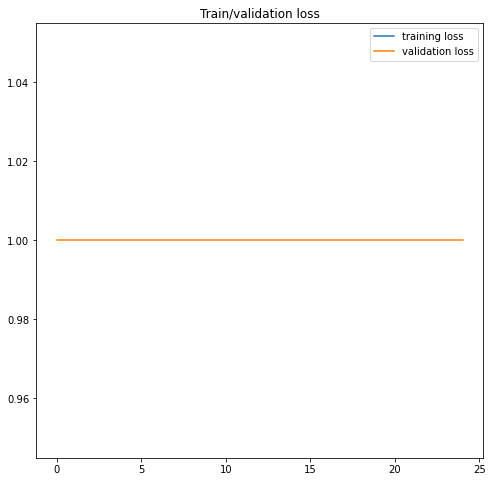

In [13]:
    # Network training...
    if train_flag == True:
        base_network = create_base_network(input_image_shape, embedding_size)

        input_images = Input(shape=input_image_shape, name='input_image') # input layer for images
        input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
        embeddings = base_network([input_images])               # output of network -> embeddings
        labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

        # Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
        model = Model(inputs=[input_images, input_labels],
                      outputs=labels_plus_embeddings)

        model.summary()
        plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

        # train session
#         opt = SGD(lr=0.0001)  # choose optimiser. RMS is good too!
        opt = SGD(lr=1e-4, momentum = 0.99)

        model.compile(loss=triplet_loss_adapted_from_tf,
                      optimizer='rmsprop')

        filepath = "semiH_trip_nut_snacks_ep{epoch:02d}_BS%d.hdf5" % batch_size
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, period=25)
        callbacks_list = [checkpoint]

        # Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
        dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
        dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

        H = model.fit(
            x=[x_train,z_train],
            y=dummy_gt_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([x_val, z_val], dummy_gt_val),
            callbacks=callbacks_list)
        
        plt.figure(figsize=(8,8))
        plt.plot(H.history['loss'], label='training loss')
        plt.plot(H.history['val_loss'], label='validation loss')
        plt.legend()
        plt.title('Train/validation loss')
        plt.show()
    else:

        model = load_model('semiH_trip_nut_snacks_ep25_BS256.hdf5',
                                        custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

### Testing if the network learned the right thing...

1. Make an empty network
2. Loop over the trained model and copy weights
3. Obtain predictions (embeddings) for test set
4. Obtain PCA decomposition
5. Visualize the separation...

In [14]:
    # Test the network

    # creating an empty network
    testing_embeddings = create_base_network(input_image_shape,
                                             embedding_size=embedding_size)
    x_embeddings_before_train = testing_embeddings.predict(np.reshape(x_test, (len(x_test), 32, 32, 3)))
    # Grabbing the weights from the trained network
    for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
        weights = layer_source.get_weights()
        layer_target.set_weights(weights)
        del weights

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fcb94551f40> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fcb94551be0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fca87ec44c0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcad0062460> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fcb76bec760> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fcad004feb0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcb76c58070> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fcb76b7ac70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcb76c16d60> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcb76677dc0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcb7667d520

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 258)               330498    
Total params: 2,588,482
Trainable params: 330,498
Non-trainable params: 2,257,984
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


NameError: name 'x_test' is not defined

In [ ]:
print(x_embeddings_before_train[0])

In [ ]:
    # Visualizing the effect of embeddings -> using PCA!

    x_embeddings = testing_embeddings.predict(np.reshape(x_test, (len(x_test), 32, 32, 3)))
    print(x_embeddings[0])
    dict_embeddings = {}
    dict_gray = {}
    test_class_labels = np.unique(np.array(y_test))

    pca = PCA(n_components=no_of_components)
    decomposed_embeddings = pca.fit_transform(x_embeddings)
#     x_test_reshaped = np.reshape(x_test, (len(x_test), 28 * 28))
    decomposed_gray = pca.fit_transform(x_embeddings_before_train)
    
    fig = plt.figure(figsize=(16, 8))
    for label in test_class_labels:
        decomposed_embeddings_class = decomposed_embeddings[y_test == label]
        decomposed_gray_class = decomposed_gray[y_test == label]

        plt.subplot(1,2,1)
        plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
        plt.title('before training (embeddings)')
        plt.legend()

        plt.subplot(1,2,2)
        plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
        plt.title('after @%d epochs' % epochs)
        plt.legend()

    plt.show()  

### Network learned how to separate the images based on their class!